In [1]:
!pip install -U deep-translator
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.2 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import pandas as pd
from deep_translator import GoogleTranslator

file_path = '/content/Ajaccio-in.csv'
df = pd.read_csv(file_path, delimiter=';', encoding='ISO-8859-1')

def translate_text(text):
    try:
        return GoogleTranslator(source='auto', target='en').translate(text)
    except Exception as e:
        return str(e)

column_to_translate = 'Interview'
df['Text-translated'] = df[column_to_translate].apply(translate_text)

output_file_path = '/content/Ajaccio-translated.csv'
df.to_csv(output_file_path, index=False, encoding='utf-8')

print(f"Translated file saved as {output_file_path}")


Translated file saved as /content/Ajaccio-translated.csv


In [4]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

file_path = '/content/Ajaccio-translated.csv'
df = pd.read_csv(file_path, encoding='utf-8')

sid = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores

df['Sentiment'] = df['Text-translated'].apply(lambda x: analyze_sentiment(x))

df_sentiments = df['Sentiment'].apply(pd.Series)

df = pd.concat([df, df_sentiments], axis=1)

output_file_path = '/content/Ajaccio-sentiments-VADER.csv'
df.to_csv(output_file_path, index=False, encoding='utf-8')

print(f"Sentiment analysis results saved as {output_file_path}")


Sentiment analysis results saved as /content/Ajaccio-sentiments.csv


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [5]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

file_path = '/content/Ajaccio-translated.csv'
df = pd.read_csv(file_path, encoding='utf-8')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)

df['Processed_Text'] = df['Text-translated'].apply(preprocess)

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_vectorized = vectorizer.fit_transform(df['Processed_Text'])

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(text_vectorized)

def get_topic_names(lda_model, vectorizer, n_top_words=10):
    topic_names = []
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda_model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_names.append(" ".join(top_features))
    return topic_names

topic_names = get_topic_names(lda, vectorizer)

themes = [
    "Education",
    "Accomodation",
    "Services",
    "Transports",
    "Environnement",
    "Religious commitment",
    "freedom",
    "security",
    "health",
    "stability",
    "natural resources",
    "cultural resources",
    "attraction",
    "image",
    "income",
    "community",
    "politics"
]

# Calculer la similarité cosinus entre les noms des topics et les thèmes
def match_topics_with_themes(topic_names, themes):
    tfidf_vectorizer = TfidfVectorizer()
    all_text = topic_names + themes
    tfidf_matrix = tfidf_vectorizer.fit_transform(all_text)

    topic_vectors = tfidf_matrix[:len(topic_names)]
    theme_vectors = tfidf_matrix[len(topic_names):]

    similarity_matrix = cosine_similarity(topic_vectors, theme_vectors)

    topic_to_theme_mapping = {}
    for topic_idx, similarities in enumerate(similarity_matrix):
        best_match_idx = np.argmax(similarities)
        topic_to_theme_mapping[topic_names[topic_idx]] = themes[best_match_idx]

    return topic_to_theme_mapping

# Associer les noms des topics aux thèmes
topic_to_theme_mapping = match_topics_with_themes(topic_names, themes)

# Associer chaque document à un topic et à un thème
doc_topic_dist = lda.transform(text_vectorized)
df['Topic'] = doc_topic_dist.argmax(axis=1)
df['Topic_Name'] = df['Topic'].apply(lambda x: topic_names[x])
df['Theme'] = df['Topic_Name'].apply(lambda x: topic_to_theme_mapping[x])

# Enregistrer les résultats dans un nouveau fichier CSV
output_file_path = '/content/Ajaccio-topic-modeling-with-vader.csv'
df.to_csv(output_file_path, index=False, encoding='utf-8')

print(f"Topic modeling results saved as {output_file_path}")





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Topic modeling results saved as /content/Ajaccio-topic-modeling.csv


In [6]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
import pandas as pd

task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

csv_file_path = '/content/Ajaccio-translated.csv'
df = pd.read_csv(csv_file_path)

labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

for index, row in df.iterrows():
    text = row['Text-translated']
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    print(f"Sentiment analysis for row {index+1}:")
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        print(f"{i+1}) {l}: {np.round(float(s), 4)}")
    print()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Sentiment analysis for row 1:
1) neutral: 0.8856
2) positive: 0.0613
3) negative: 0.0531

Sentiment analysis for row 2:
1) neutral: 0.521
2) negative: 0.4146
3) positive: 0.0644

Sentiment analysis for row 3:
1) neutral: 0.4899
2) negative: 0.2652
3) positive: 0.2449

Sentiment analysis for row 4:
1) neutral: 0.7761
2) positive: 0.1812
3) negative: 0.0427

Sentiment analysis for row 5:
1) negative: 0.7647
2) neutral: 0.2214
3) positive: 0.0139

Sentiment analysis for row 6:
1) neutral: 0.866
2) negative: 0.1093
3) positive: 0.0247

Sentiment analysis for row 7:
1) neutral: 0.6153
2) negative: 0.2281
3) positive: 0.1566

Sentiment analysis for row 8:
1) negative: 0.6823
2) neutral: 0.2977
3) positive: 0.0201

Sentiment analysis for row 9:
1) neutral: 0.7992
2) negative: 0.1101
3) positive: 0.0908

Sentiment analysis for row 10:
1) neutral: 0.6216
2) negative: 0.2905
3) positive: 0.0879

Sentiment analysis for row 11:
1) negative: 0.7522
2) neutral: 0.2246
3) positive: 0.0232

Sentiment 

In [7]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
import pandas as pd

task = 'sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

csv_file_path = 'Ajaccio-translated.csv'
df = pd.read_csv(csv_file_path)

labels = []
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

sentiment_scores = []
for index, row in df.iterrows():
    text = row['Text-translated']
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    score_dict = {labels[i]: scores[i] for i in range(len(labels))}
    sentiment_scores.append(score_dict)
    print(f"Sentiment analysis for row {index+1}: {score_dict}")

df['score-sentiment analysis'] = sentiment_scores

output_file_path = 'Ajaccio-translated-with-roberta.csv'
df.to_csv(output_file_path, index=False, encoding='utf-8-sig')

print(f"Le fichier traduit avec analyse des sentiments a été enregistré sous {output_file_path}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentiment analysis for row 1: {'negative': 0.053105853, 'neutral': 0.88557994, 'positive': 0.06131431}
Sentiment analysis for row 2: {'negative': 0.414551, 'neutral': 0.52100253, 'positive': 0.064446464}
Sentiment analysis for row 3: {'negative': 0.26519156, 'neutral': 0.48994032, 'positive': 0.24486816}
Sentiment analysis for row 4: {'negative': 0.04272874, 'neutral': 0.7760757, 'positive': 0.18119556}
Sentiment analysis for row 5: {'negative': 0.7646791, 'neutral': 0.2213814, 'positive': 0.013939547}
Sentiment analysis for row 6: {'negative': 0.10933923, 'neutral': 0.8659872, 'positive': 0.024673594}
Sentiment analysis for row 7: {'negative': 0.22814037, 'neutral': 0.61527926, 'positive': 0.15658036}
Sentiment analysis for row 8: {'negative': 0.68225616, 'neutral': 0.29765117, 'positive': 0.020092627}
Sentiment analysis for row 9: {'negative': 0.110056005, 'neutral': 0.7991846, 'positive': 0.09075938}
Sentiment analysis for row 10: {'negative': 0.29046404, 'neutral': 0.6216195, 'posi

In [ ]:
import torch


import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel

def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

input_texts = [
    "query: Several participants note, however, that this security climate is deteriorating, even though they have not necessarily had bad experiences but by listening to those around them, and by planning for the long term, but also for an older participant who remarks that compared to what she knew before has deteriorated a lot."

]

themes = [
    "Education",
    "Accomodation",
    "Services",
    "Transports",
    "Environnement",
    "Religious commitment",
    "freedom",
    "security",
    "health",
    "stability",
    "natural resources",
    "cultural resources",
    "attraction",
    "image",
    "income",
    "community",
    "politics"
]

tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-small')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-small')

input_batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
theme_batch_dict = tokenizer(themes, max_length=512, padding=True, truncation=True, return_tensors='pt')

input_outputs = model(**input_batch_dict)
theme_outputs = model(**theme_batch_dict)

input_embeddings = average_pool(input_outputs.last_hidden_state, input_batch_dict['attention_mask'])
theme_embeddings = average_pool(theme_outputs.last_hidden_state, theme_batch_dict['attention_mask'])

input_embeddings = F.normalize(input_embeddings, p=2, dim=1)
theme_embeddings = F.normalize(theme_embeddings, p=2, dim=1)

scores = torch.matmul(input_embeddings, theme_embeddings.T) * 100

top_scores, top_indices = torch.max(scores, dim=1)

top_themes = [themes[idx] for idx in top_indices.tolist()]

for i, text in enumerate(input_texts):
    print(f"Text: {text}")
    print(f"Most similar theme: {top_themes[i]} (Score: {top_scores[i].item():.2f})")
    print()




Text: query: Several participants note, however, that this security climate is deteriorating, even though they have not necessarily had bad experiences but by listening to those around them, and by planning for the long term, but also for an older participant who remarks that compared to what she knew before has deteriorated a lot.
Most similar theme: sécurité (Score: 80.53)



In [ ]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel

def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

def predict_theme(text, themes, tokenizer, model):
    input_text = f"query: {text}"
    input_texts = [input_text]

    input_batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
    theme_batch_dict = tokenizer(themes, max_length=512, padding=True, truncation=True, return_tensors='pt')

    input_outputs = model(**input_batch_dict)
    theme_outputs = model(**theme_batch_dict)

    input_embeddings = average_pool(input_outputs.last_hidden_state, input_batch_dict['attention_mask'])
    theme_embeddings = average_pool(theme_outputs.last_hidden_state, theme_batch_dict['attention_mask'])

    input_embeddings = F.normalize(input_embeddings, p=2, dim=1)
    theme_embeddings = F.normalize(theme_embeddings, p=2, dim=1)

    scores = torch.matmul(input_embeddings, theme_embeddings.T) * 100

    top_scores, top_indices = torch.max(scores, dim=1)
    top_theme = themes[top_indices[0].item()]
    top_score = top_scores[0].item()

    return top_theme, top_score

tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-small')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-small')

themes = [
    "Education",
    "Accomodation",
    "Services",
    "Transports",
    "Environnement",
    "Religious commitment",
    "Freedom",
    "Security",
    "Health",
    "Stability",
    "Natural resources",
    "Cultural resources",
    "Attraction",
    "Image",
    "Income",
    "Community",
    "Politics"
]

df = pd.read_csv('/content/Ajaccio-translated-with-roberta.csv')

df['theme-predicted'] = df['Text-translated'].apply(lambda text: predict_theme(text, themes, tokenizer, model))

df[['theme-predicted', 'similarity-score']] = pd.DataFrame(df['theme-predicted'].tolist(), index=df.index)

df.to_csv('/content/Topic-modeling.csv', index=False)

print(df)


    Id_Interview                                  Thème  \
0              1                              Remarques   
1              2                              Remarques   
2              3                              Remarques   
3              4                              Seécurité   
4              5                              Seécurité   
5              6                               Sécurité   
6              7                               Sécurité   
7              8                               Sécurité   
8              9                               Sécurité   
9             10                               Sécurité   
10            11                             Sallubrité   
11            12                             Sallubrité   
12            13                          Pollution air   
13            14                      Réseau et télécom   
14            15                      Réseau et télécom   
15            16                      Réseau et télécom 

In [ ]:
import pandas as pd

# Charger les données depuis le fichier CSV
df = pd.read_csv('/content/Topic-modeling.csv')

# Extract sentiment scores
df['negative'] = df['score-sentiment analysis'].apply(lambda x: eval(x)['negative'])
df['neutral'] = df['score-sentiment analysis'].apply(lambda x: eval(x)['neutral'])
df['positive'] = df['score-sentiment analysis'].apply(lambda x: eval(x)['positive'])

# Convert sentiment scores to numeric (just in case)
df['negative'] = pd.to_numeric(df['negative'], errors='coerce')
df['neutral'] = pd.to_numeric(df['neutral'], errors='coerce')
df['positive'] = pd.to_numeric(df['positive'], errors='coerce')

print(df.head())


   Id_Interview      Thème                                          Interview  \
0             1  Remarques  Une forte influence de lactualité dans le cho...   
1             2  Remarques  Dautres critères ont été cités même si pas cl...   
2             3  Remarques  Une des participantes a grandi au village et v...   
3             4  Seécurité  Peu impactés en Corse même si certains quartie...   
4             5  Seécurité  Cest un critère déterminant dans le choix de ...   

                                     Text-translated  \
0  A strong influence of current events in the ch...   
1  Other criteria were cited even if not classifi...   
2  One of the participants grew up in the village...   
3  Little impacted in Corsica even if certain nei...   
4  This is a determining criterion in the choice ...   

                            score-sentiment analysis       theme-predicted  \
0  {'negative': 0.053105853, 'neutral': 0.8855799...  Religious commitment   
1  {'negative': 0.41

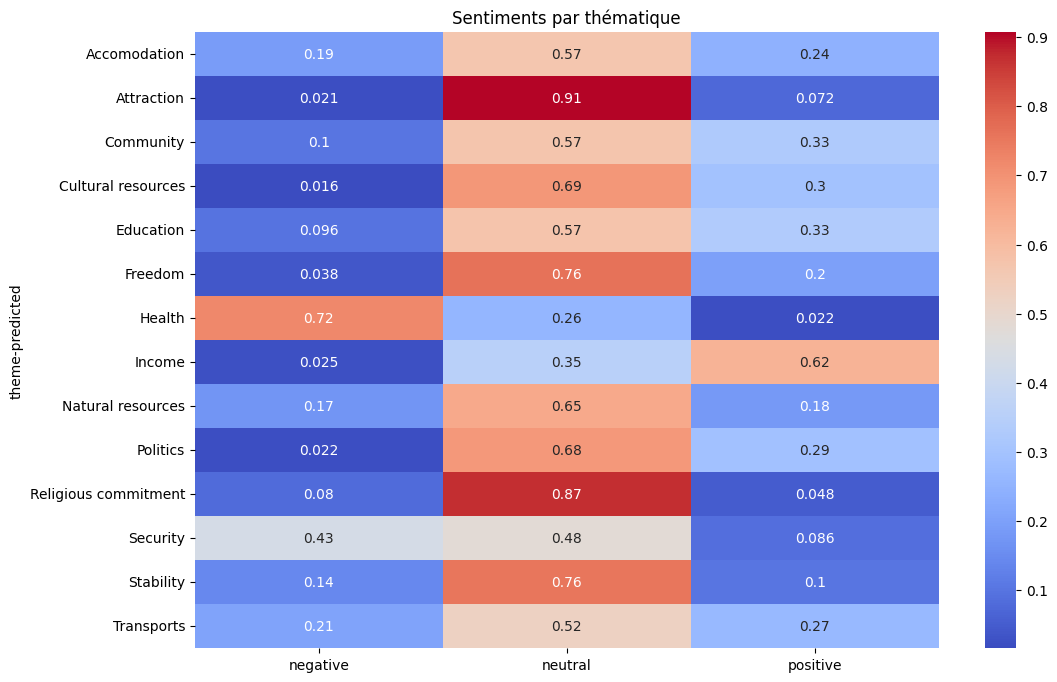

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Agréger les sentiments par thématique
theme_sentiment = df.groupby('theme-predicted')[['negative', 'neutral', 'positive']].mean()

# Créer une carte thermique
plt.figure(figsize=(12, 8))
sns.heatmap(theme_sentiment, annot=True, cmap='coolwarm')
plt.title('Sentiments par thématique')
plt.show()
